# IDTreeS competition dataset

## Refs and links

[Dataset](https://zenodo.org/record/3934932) from the [IDTreeS competition, 2020](https://idtrees.org/competition/):

* `train`: task 1 training dataset from [IDTREES_competition_train_v2.zip](https://zenodo.org/record/3934932/files/IDTREES_competition_train_v2.zip?download=1);
* `test`: test dataset from [IDTREES_competition_test_v2.zip](https://zenodo.org/record/3934932/files/IDTREES_competition_test_v2.zip?download=1).

## Exploring the training dataset

We look at the only true-color images (RGB), while the dataset also includes hyperspectral images(HSI), point-cloud data (LAS) and canopy height model (CHM). Individual tree-crowns (ITCs) are provided as vector data. 

In [1]:
import geopandas
import matplotlib.pyplot as plt
import rioxarray

In [2]:
# data paths
region = 'MLBS'
rgb_path = f'./train/RemoteSensing/RGB/{region}_1.tif'  # first sample
labels_path = f'./train/ITC/train_{region}.shp'

In [3]:
rgb = rioxarray.open_rasterio(rgb_path, masked=True)

In [4]:
rgb.rio.crs

CRS.from_epsg(32617)

In [5]:
# load labels
labels = geopandas.read_file(labels_path)

In [6]:
labels.crs

<Projected CRS: EPSG:32617>
Name: WGS 84 / UTM zone 17N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°W and 78°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Ecuador - north of equator. Canada - Nunavut; Ontario; Quebec. Cayman Islands. Colombia. Costa Rica. Cuba. Jamaica. Nicaragua. Panama. United States (USA).
- bounds: (-84.0, 0.0, -78.0, 84.0)
Coordinate Operation:
- name: UTM zone 17N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x', ylabel='y'>

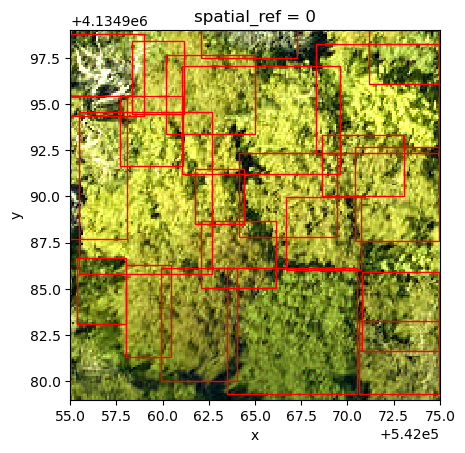

In [7]:
# plot labels within the sample
fig, ax = plt.subplots()
rgb.plot.imshow(ax=ax, robust=True)
xmin, ymin, xmax, ymax = rgb.rio.bounds()
# labels_clip = labels.clip_by_rect(xmin, ymin, xmax, ymax)
labels_clip = labels.cx[xmin:xmax, ymin:ymax]
labels_clip = labels_clip[~labels_clip.is_empty]
labels_clip.plot(ax=ax, facecolor='none', edgecolor='red')

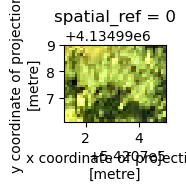

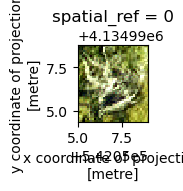

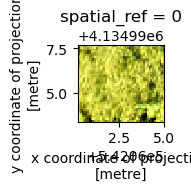

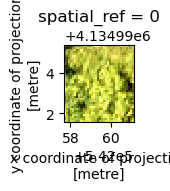

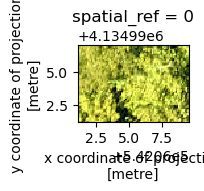

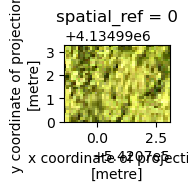

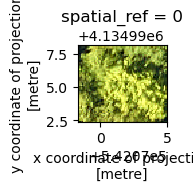

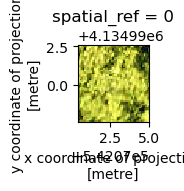

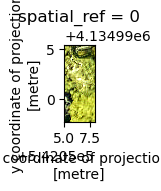

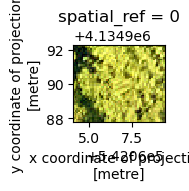

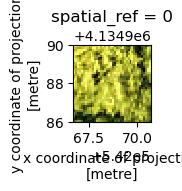

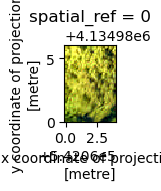

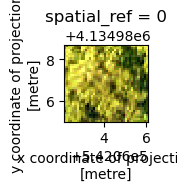

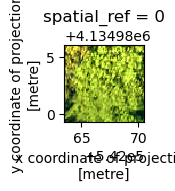

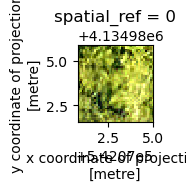

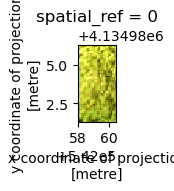

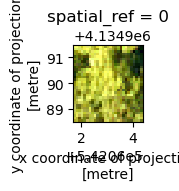

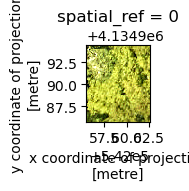

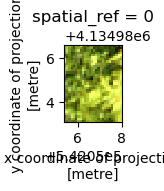

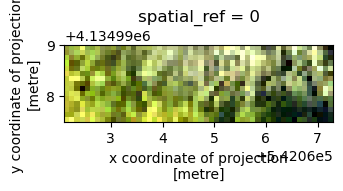

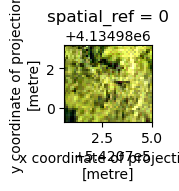

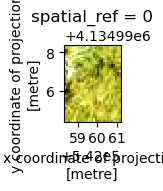

In [9]:
# plot all the extracts
# for label in labels_clip:
for label in labels_clip.geometry:
    cutout = rgb.rio.clip([label], drop=True)
    aspect = cutout.rio.width / cutout.rio.height
    cutout.plot.imshow(robust=True, aspect=aspect, size=1, x='x', y='y')
    plt.show()

## Set up data loader

In [10]:
import glob

import tensorflow as tf

2023-08-29 12:49:01.638154: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [48]:
region = 'MLBS'
rgb_paths = glob.glob(f'./train/RemoteSensing/RGB/{region}_*.tif')
labels_path = f'./train/ITC/train_{region}.shp'

In [68]:
class IDTreeSDataset:
    def __init__(self, rgb_paths, labels_path):
        self.rgb_paths = rgb_paths
        self.labels_path = labels_path
        
    def generate_cutouts(self):
        labels = geopandas.read_file(labels_path)
        for rgb_path in rgb_paths:
            rgb = rioxarray.open_rasterio(rgb_path, masked=True)
            assert labels.crs == rgb.rio.crs
            xmin, ymin, xmax, ymax = rgb.rio.bounds()
            labels_clip = labels.cx[xmin:xmax, ymin:ymax]
            for label in labels_clip.geometry:
                # print(rgb_path, label)
                cutout = rgb.rio.clip([label], drop=True)        
                yield cutout.data.transpose(1, 2, 0)

In [69]:
ds = IDTreeSDataset(rgb_paths, labels_path)
cutouts = ds.generate_cutouts()

In [79]:
ds = IDTreeSDataset(rgb_paths, labels_path)

ds = tf.data.Dataset.from_generator(
    ds.generate_cutouts,
    output_signature=(
        tf.TensorSpec(shape=(None, None, 3), dtype=tf.float32)
    )
)

In [82]:
for el in ds.batch(1):
    print(el)

2023-08-29 13:36:32.197139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


tf.Tensor(
[[[[127. 162.  85.]
   [133. 137.  98.]
   [123. 147.  79.]
   [107. 137.  59.]
   [113. 118.  85.]
   [ 98. 105.  57.]
   [ 91.  99.  66.]
   [136. 131.  80.]
   [185. 197. 120.]
   [152. 179. 102.]
   [131. 137.  65.]
   [136. 169.  84.]
   [157. 171. 104.]
   [175. 170. 109.]
   [177. 187. 117.]
   [139. 151.  83.]
   [119. 136.  86.]
   [ 97. 104.  66.]
   [ 89. 100.  60.]
   [ 94. 111.  71.]
   [127. 143.  84.]
   [125. 139.  82.]
   [ 85.  97.  51.]
   [ 96. 110.  56.]
   [132. 146.  81.]
   [127. 135.  73.]
   [127. 127.  69.]
   [174. 186. 111.]
   [161. 177.  95.]
   [173. 183. 122.]
   [145. 171.  94.]
   [144. 156.  91.]
   [145. 165.  94.]
   [127. 134.  71.]
   [ 81.  93.  36.]
   [166. 180. 100.]
   [171. 183. 102.]
   [147. 159. 100.]
   [ 84.  86.  69.]
   [ 67.  79.  56.]
   [ 42.  64.  53.]
   [ 58.  68.  58.]
   [ 46.  65.  55.]
   [ 69.  79.  57.]
   [ 76.  82.  67.]
   [ 78.  89.  61.]
   [ 77.  90.  68.]
   [ 79.  84.  69.]
   [ 78.  84.  52.]
   [ 89. 

2023-08-29 13:36:32.714499: W tensorflow/core/framework/op_kernel.cc:1818] UNKNOWN: NoDataInBounds: No data found in bounds.
Traceback (most recent call last):

  File "/opt/miniconda3/envs/xai4geo/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/opt/miniconda3/envs/xai4geo/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/opt/miniconda3/envs/xai4geo/lib/python3.11/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/var/folders/t6/r2gjczqj7bb8798wr4g1p87m0000gn/T/ipykernel_45971/3934292201.py", line 15, in generate_cutouts
    cutout = rgb.rio.clip([label], drop=True)
     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} NoDataInBounds: No data found in bounds.
Traceback (most recent call last):

  File "/opt/miniconda3/envs/xai4geo/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/opt/miniconda3/envs/xai4geo/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/opt/miniconda3/envs/xai4geo/lib/python3.11/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/var/folders/t6/r2gjczqj7bb8798wr4g1p87m0000gn/T/ipykernel_45971/3934292201.py", line 15, in generate_cutouts
    cutout = rgb.rio.clip([label], drop=True)
     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/opt/miniconda3/envs/xai4geo/lib/python3.11/site-packages/rioxarray/raster_array.py", line 923, in clip
    raise NoDataInBounds(

rioxarray.exceptions.NoDataInBounds: No data found in bounds.


	 [[{{node PyFunc}}]] [Op:IteratorGetNext]